In [ ]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pandas as pd


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


In [58]:
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30
B = 145**4  # MeV^4
hc = 197.3269804  # MeV*fm
    
factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B

# Ratio

$$
R = \frac{p_{DM}}{p_{QM}}
$$

In [ ]:

def compute_two_fluid_properties_ratio(e_quark, p_quark, R, grid_e_quark, grid_p_quark, grid_e_dm, grid_p_dm, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    m_quark_c = (4/3) * np.pi * r0**3 * e_quark
    
    # Dark Matter ICs
    p_dm = p_quark * R
    e_dm = np.interp(p_dm, grid_p_dm, grid_e_dm)
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm
    
    x0 = [p_quark, m_quark_c, p_dm, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_dm, grid_e_dm)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = -1.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = -1.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Events 
    # ----------------------------------------------------

    # Event Quark Surface (do not stop)
    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = False 
    event_Quark_surface.direction = -1

    # Event DM Surface (do not stop)
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    # Event C: Stop Integration
    def event_Stop_Integration(r, x):
        return max(x[0], x[2])
    event_Stop_Integration.terminal = True
    event_Stop_Integration.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_Quark_surface, event_DM_surface,  event_Stop_Integration],
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7
    )

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        #print(f"Quark Surface detected at R = {R_quark_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        #print(f"DM Surface detected at R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")


    M1_phys = m1_adim * factor_M_to_Solar
    M2_phys = m2_adim * factor_M_to_Solar

    M_total = M1_phys + M2_phys

    results = {
        "R_quark": R_quark_final * factor_R_to_km,
        "R_dm": R_DM_final * factor_R_to_km ,
        "M_total": M_total[-1],
        "M_quark": M1_phys[-1],
        "M_dm": M2_phys[-1]
    }
    return results


For only EOS I: R=0

In [ ]:

data = pd.read_csv('../Data/EOSII_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_2 = (10 ** data['x']) * hc **3 / (4*B) #dimensionless
grid_p_2 = (10 ** data[' y']) * hc **3 / (4*B) #dimensionless

central_energy_densities_phys = np.linspace(10,2e3,10000) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) # dimensionless
central_pressures = np.interp(central_energy_densities, grid_e_2, grid_p_2) # dimensionless

grid_e_eos2 = central_energy_densities
grid_p_eos2 = central_pressures


data = pd.read_csv('../Data/EOS1_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_1 = (10 ** data['x']) * hc **3 / (4*B)
grid_p_1 = (10 ** data[' y']) * hc **3 / (4*B)


central_energy_densities_phys = np.linspace(10,2e3,10000) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_1, grid_p_1)

grid_e_eos1 = central_energy_densities
grid_p_eos1 = central_pressures

central_energy_densities_phys = np.linspace(10,2e3,100) # MeV/fm^3
central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_eos1, grid_p_eos1)

list_Rqm_0 = []
list_Rdm_0 = []
list_M_0 = []
list_Mqm_0 = []
list_Mdm_0 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_eos1, grid_p_quark=grid_p_eos1, grid_e_dm=grid_e_eos1, grid_p_dm=grid_e_eos1)
    list_Rqm_0.append(data['R_quark'])
    list_Rdm_0.append(data['R_dm'])
    list_M_0.append(data['M_total'])
    list_Mqm_0.append(data['M_quark'])
    list_Mdm_0.append(data['M_dm'])


central_pressures = np.interp(central_energy_densities, grid_e_eos2, grid_p_eos2)

list_Rqm_0_eos2 = []
list_Rdm_0_eos2 = []
list_M_0_eos2 = []
list_Mqm_0_eos2 = []
list_Mdm_0_eos2 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_eos2, grid_p_quark=grid_p_eos2, grid_e_dm=grid_e_eos1, grid_p_dm=grid_p_eos1)
    list_Rqm_0_eos2.append(data['R_quark'])
    list_Rdm_0_eos2.append(data['R_dm'])
    list_M_0_eos2.append(data['M_total'])
    list_Mqm_0_eos2.append(data['M_quark'])
    list_Mdm_0_eos2.append(data['M_dm'])


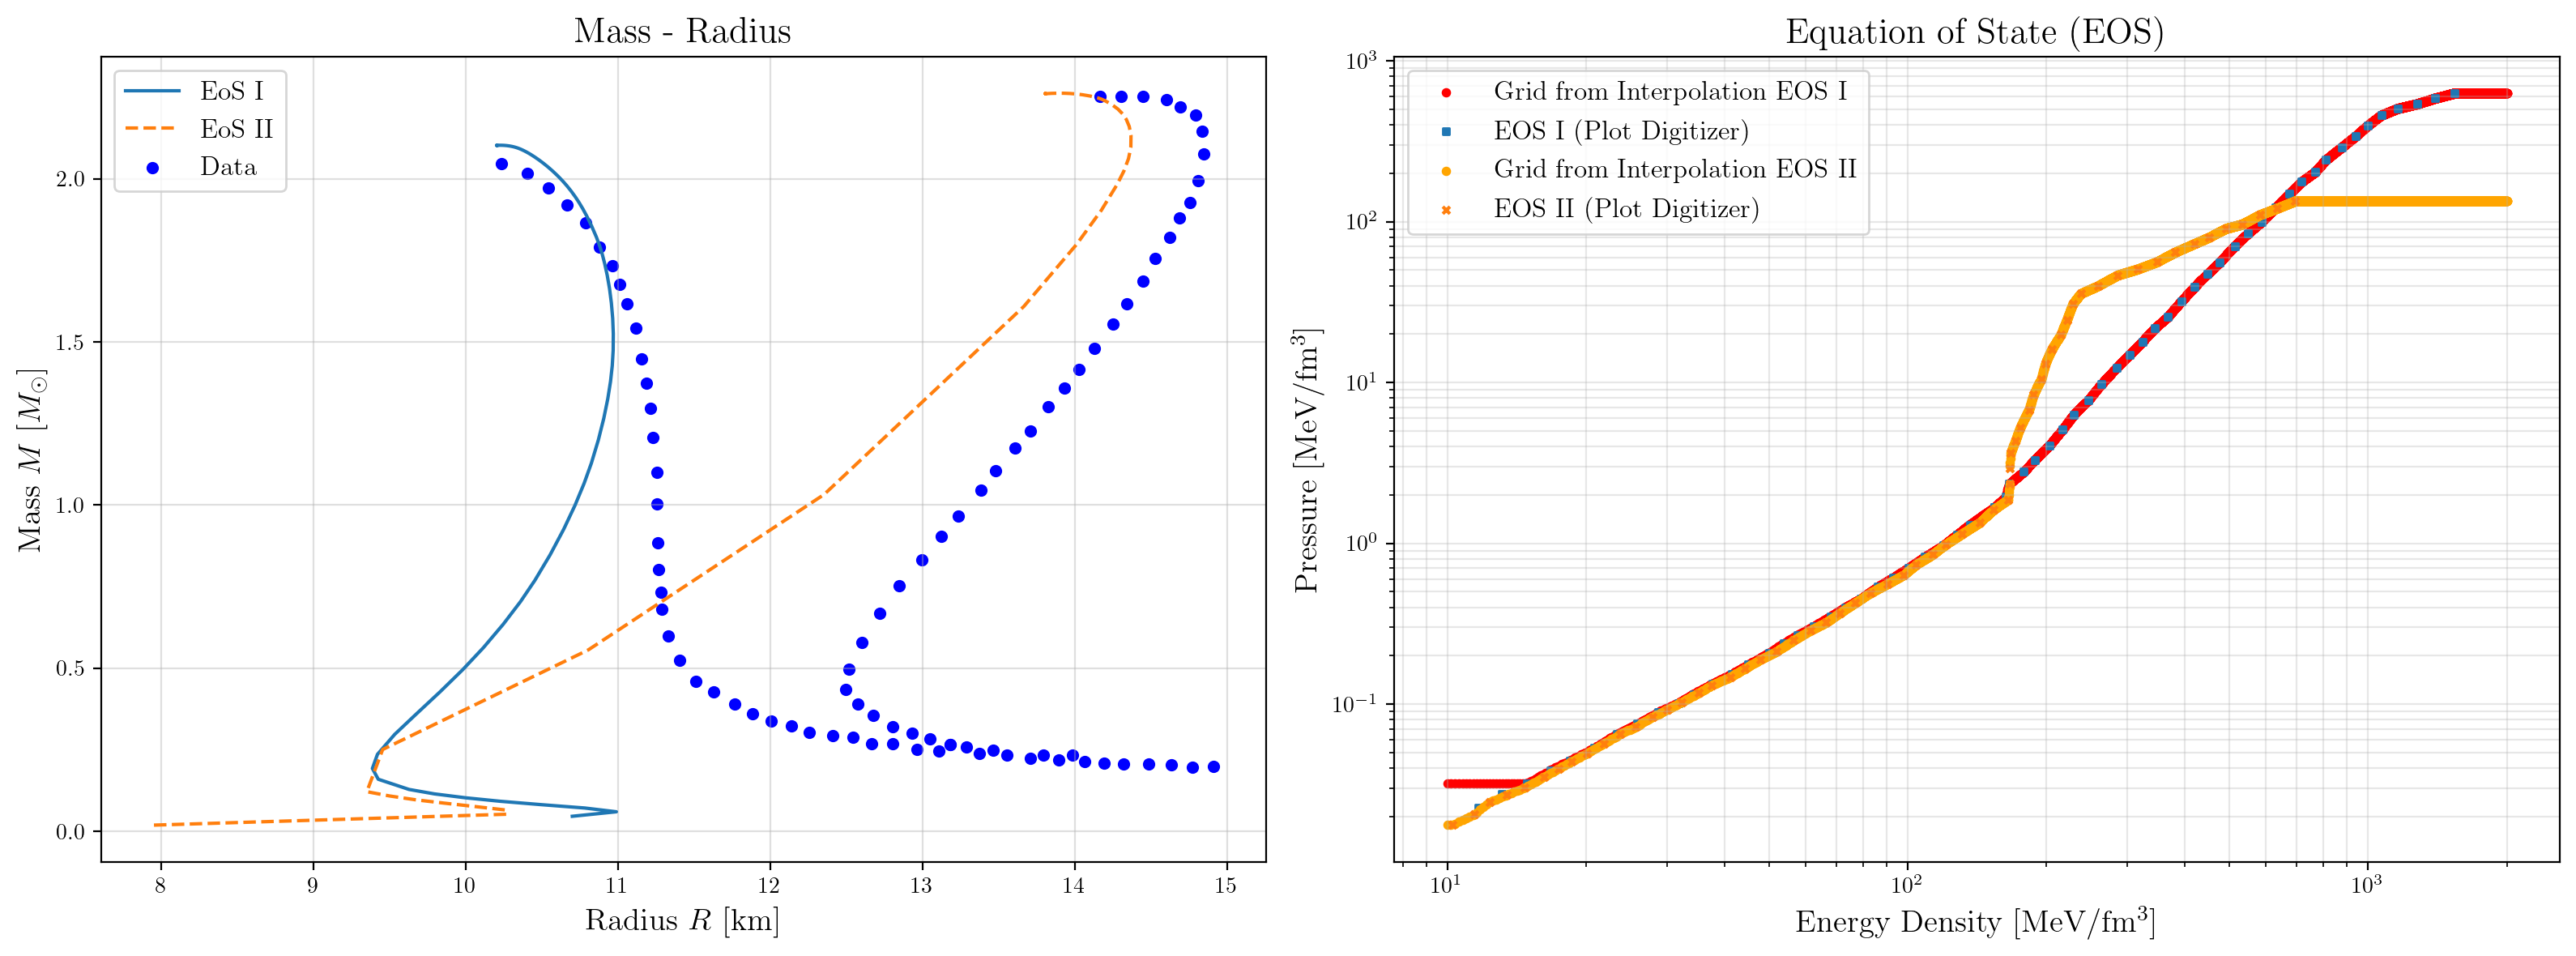

In [96]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

#open a csv file
mr = pd.read_csv('../Data/Mass_radius_EOS1andEOS2.csv')

# --- Plot 1: Mass-Radius Diagram (Left) ---
axs[0].plot(list_Rqm_0, list_M_0, label=r'EoS I')
axs[0].plot(list_Rqm_0_eos2, list_M_0_eos2, label=r'EoS II', linestyle='--') # Added dashed line for contrast
axs[0].scatter(mr['x'], mr[' y'], color='blue', s=20, label='Data')
axs[0].set_xlabel(r'Radius $R$ [km]', fontsize=14)
axs[0].set_ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0].set_title(r' Mass - Radius', fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# --- Plot 2: Equation of State (Right) ---
# EOS I Data

axs[1].scatter(grid_e_eos1 * (4 * B) / hc**3, grid_p_eos1 * (4 * B) / hc**3, color='red', s=10, label='Grid from Interpolation EOS I')
axs[1].scatter(grid_e_1 * (4 * B) / hc**3, grid_p_1 * (4 * B) / hc**3, label='EOS I (Plot Digitizer)', s=10, marker='s')

# EOS II Data

axs[1].scatter(grid_e_eos2 * (4 * B) / hc**3, grid_p_eos2 * (4 * B) / hc**3, color='orange', s=10, label='Grid from Interpolation EOS II')
axs[1].scatter(grid_e_2* (4 * B) / hc**3, grid_p_2* (4 * B) / hc**3, label='EOS II (Plot Digitizer)', s=10, marker='x') # Changed color/marker

# EOS Plot Formatting
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel('Pressure [MeV/fm$^3$]', fontsize=14)
axs[1].set_xlabel('Energy Density [MeV/fm$^3$]', fontsize=14)
axs[1].set_title('Equation of State (EOS)', fontsize=16)
axs[1].legend(fontsize=12)
axs[1].grid(True, which="both", alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

The problem is not the interpolation.

More code that doesnt work either

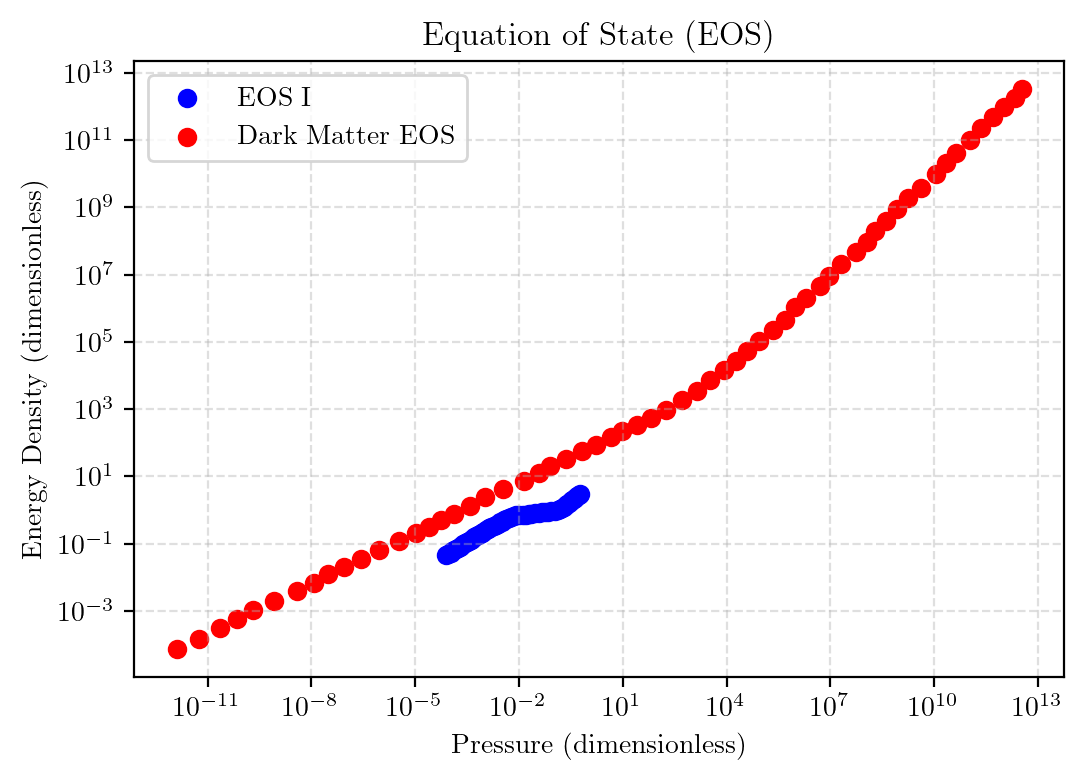

In [37]:
# open a data file
data = pd.read_csv('../Data/EOSII_Mikel.csv') #Mev/fm3

m_f = 1e3  # MeV

data_dimensionless = data.copy()

# Extract columns
grid_e_quark = (10 ** data_dimensionless['x']) * hc **3 / (4*B)
grid_p_quark = (10 ** data_dimensionless[' y']) * hc **3 / (4*B)


data = pd.read_csv('../Data/EOS_DM_Mikel.csv') # it is dimensionless but must be corrected

data_dimensionless = data.copy() 

# Extract columns
grid_e_dm = (10 ** data_dimensionless['x']) * m_f **4  * hc **3 / (4*B)
grid_p_dm = (10 ** data_dimensionless[' y']) * m_f **4  * hc **3 / (4*B)


#plot both eos in log scale
plt.figure(figsize=(6,4))
plt.scatter(grid_p_quark, grid_e_quark, label='EOS I', color='blue')
plt.scatter(grid_p_dm, grid_e_dm, label='Dark Matter EOS', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pressure (dimensionless)')
plt.ylabel('Energy Density (dimensionless)')
plt.title('Equation of State (EOS)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Two fluid

# Ratio

$$
R = \frac{p_{DM}}{p_{QM}}
$$

In [ ]:
def compute_two_fluid_properties_ratio(e_quark, p_quark, R, grid_e_quark, grid_p_quark, grid_e_dm, grid_p_dm, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    m_quark_c = (4/3) * np.pi * r0**3 * e_quark
    
    # Dark Matter ICs
    p_dm = p_quark * R
    e_dm = np.interp(p_dm, grid_p_dm, grid_e_dm)
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm
    
    x0 = [p_quark, m_quark_c, p_dm, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_dm, grid_e_dm)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = -1.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = -1.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # 3. Events 
    # ----------------------------------------------------

    # Event Quark Surface (do not stop)
    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = False 
    event_Quark_surface.direction = -1

    # Event DM Surface (do not stop)
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    # Event C: Stop Integration
    def event_Stop_Integration(r, x):
        return max(x[0], x[2])
    event_Stop_Integration.terminal = True
    event_Stop_Integration.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_Quark_surface, event_DM_surface,  event_Stop_Integration],
        rtol=1e-8, 
        atol=1e-10,
        first_step=1e-7
    )

    r_adim = sol.t.copy()
    p1_adim = sol.y[0].copy()
    m1_adim = sol.y[1].copy()
    p2_adim = sol.y[2].copy()
    m2_adim = sol.y[3].copy()

    # --- EXTRACT EXACT RADII FROM EVENTS ---
    # sol.t_events is a list containing the R values for each event function.
    # Index [0] corresponds to event_Quark_surface
    # Index [1] corresponds to event_DM_surface

    # 1. Quark Matter Handling
    if len(sol.t_events[0]) > 0:
        R_quark_final = sol.t_events[0][0] # Take the first crossing
        #print(f"Quark Surface detected at R = {R_quark_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        # This replaces the manual index search
        p1_adim[r_adim > R_quark_final] = 0.0
    else:
        R_quark_final = None
        print("Quark pressure never crossed zero (or started at 0).")

    # 2. Dark Matter Handling
    if len(sol.t_events[1]) > 0:
        R_DM_final = sol.t_events[1][0] # Take the first crossing
        #print(f"DM Surface detected at R = {R_DM_final:.4e}")
        
        # Clean up: Force pressure to 0 for all r > R_surface
        p2_adim[r_adim > R_DM_final] = 0.0
    else:
        R_DM_final = None
        print("DM pressure never crossed zero (or started at 0).")


    M1_phys = m1_adim * factor_M_to_Solar
    M2_phys = m2_adim * factor_M_to_Solar

    M_total = M1_phys + M2_phys

    results = {
        "R_quark": R_quark_final * factor_R_to_km,
        "R_dm": R_DM_final * factor_R_to_km ,
        "M_total": M_total[-1],
        "M_quark": M1_phys[-1],
        "M_dm": M2_phys[-1]
    }
    return results


In [39]:
central_energy_densities_phys = np.linspace(250,1e4,200) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_quark, grid_p_quark)

list_Rqm_1e_6 = []
list_Rdm_1e_6 = []
list_M_1e_6 = []
list_Mqm_1e_6 = []
list_Mdm_1e_6 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1e-6, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_1e_6.append(data['R_quark'])
    list_Rdm_1e_6.append(data['R_dm'])
    list_M_1e_6.append(data['M_total'])
    list_Mqm_1e_6.append(data['M_quark'])
    list_Mdm_1e_6.append(data['M_dm'])


list_Rqm_1 = []
list_Rdm_1 = []
list_M_1 = []
list_Mqm_1 = []
list_Mdm_1 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_1.append(data['R_quark'])
    list_Rdm_1.append(data['R_dm'])
    list_M_1.append(data['M_total'])
    list_Mqm_1.append(data['M_quark'])
    list_Mdm_1.append(data['M_dm'])

list_Rqm_100 = []
list_Rdm_100 = []
list_M_100 = []
list_Mqm_100 = []
list_Mdm_100 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=100, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_100.append(data['R_quark'])
    list_Rdm_100.append(data['R_dm'])
    list_M_100.append(data['M_total'])
    list_Mqm_100.append(data['M_quark'])
    list_Mdm_100.append(data['M_dm'])


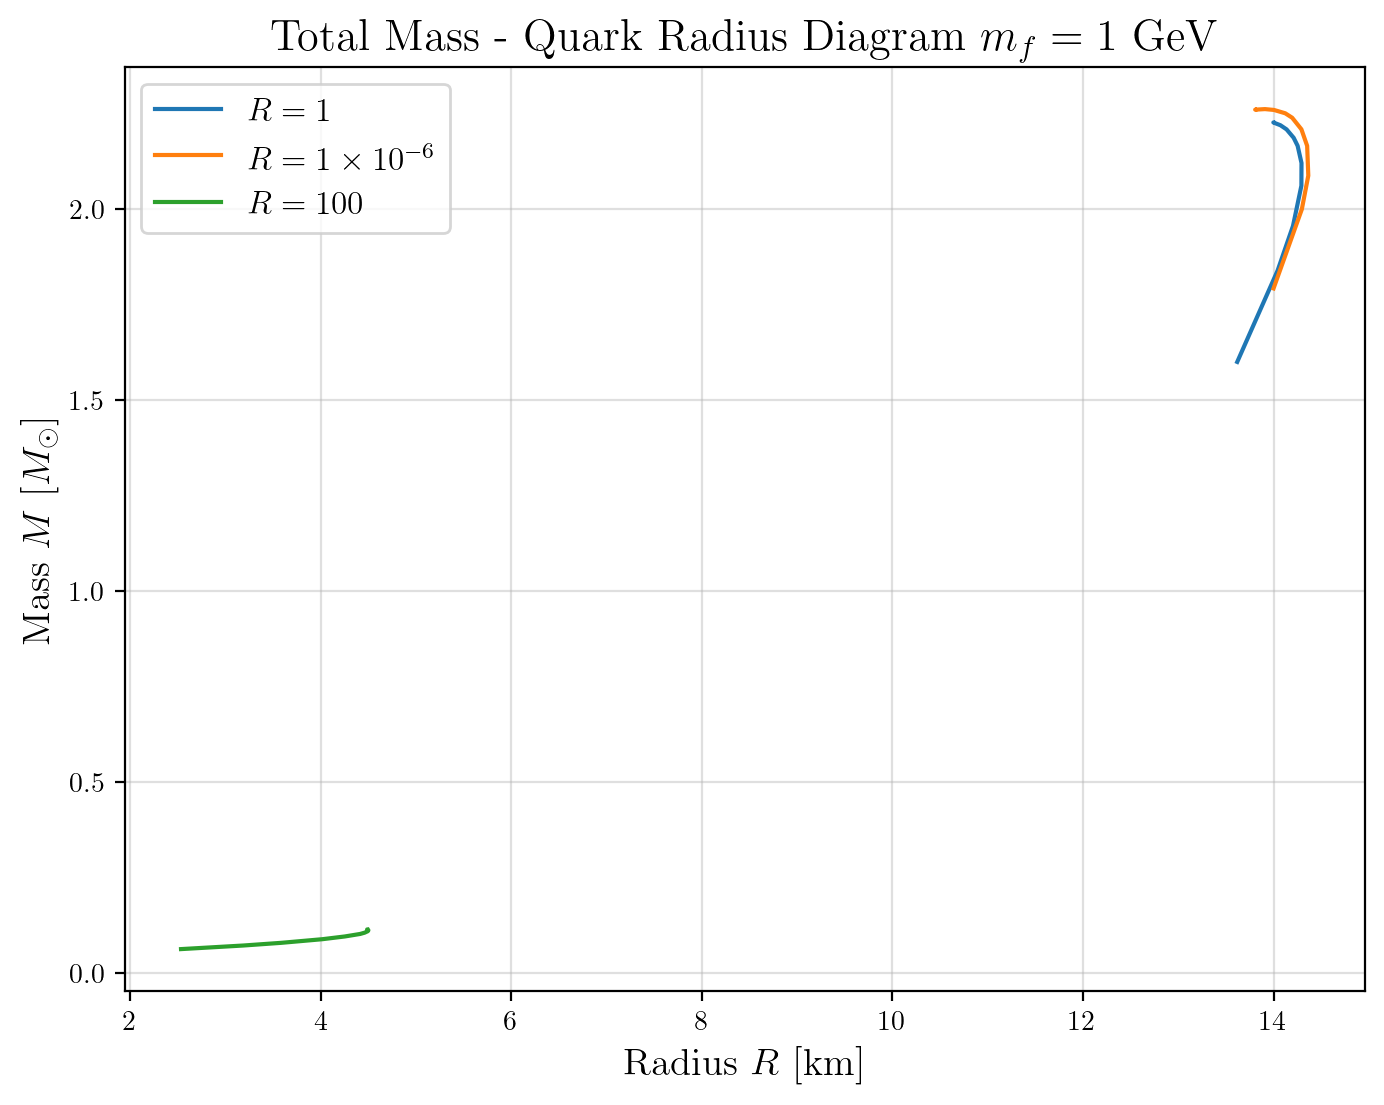

In [40]:
#plot Mass-Radius Diagram
plt.figure(figsize=(8,6))

plt.plot(list_Rqm_1, list_M_1, label=r'$R = 1$')
plt.plot(list_Rqm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
plt.plot(list_Rqm_100, list_M_100, label=r'$R = 100$')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'Radius $R$ [km]', fontsize=14)
plt.ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
plt.title('Total Mass - Quark Radius Diagram $m_f =1 $ GeV', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

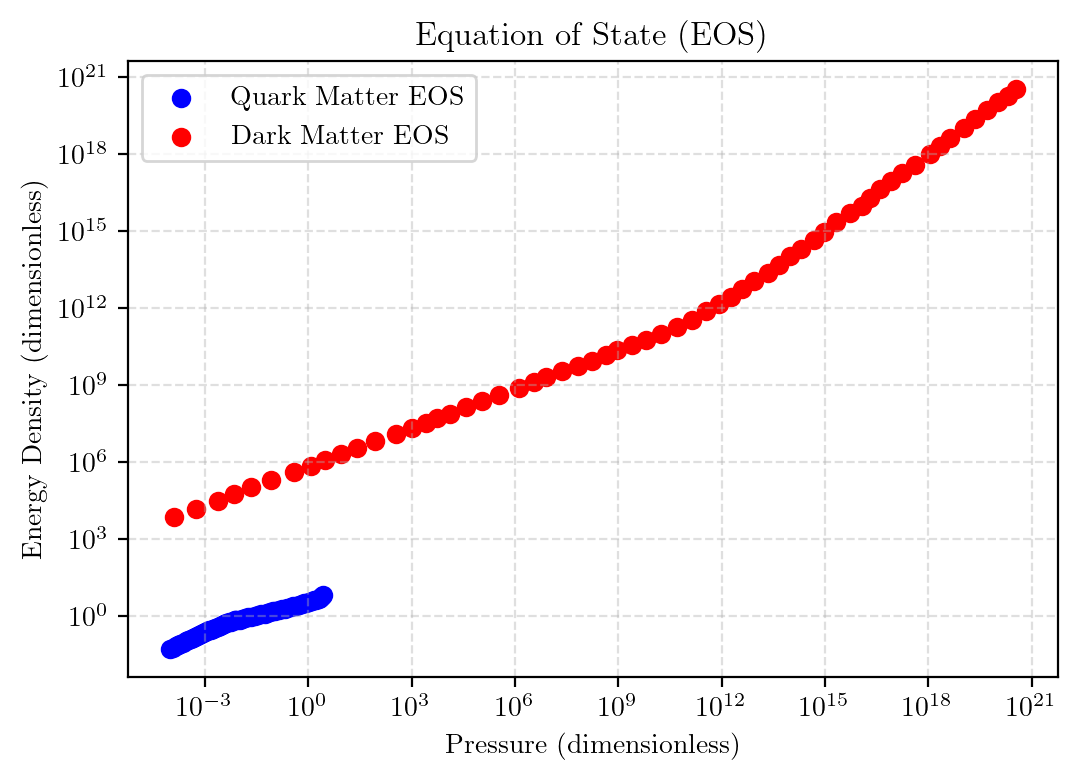

In [41]:


# open a data file
data = pd.read_csv('../Data/EOS1_Mikel.csv') #Mev/fm3

m_f = 1e5  # MeV

data_dimensionless = data.copy()

# Extract columns
grid_e_quark = (10 ** data_dimensionless['x']) * hc **3 / (4*B)
grid_p_quark = (10 ** data_dimensionless[' y']) * hc **3 / (4*B)


data = pd.read_csv('../Data/EOS_DM_Mikel.csv') # it is dimensionless but must be corrected

data_dimensionless = data.copy() 

# Extract columns
grid_e_dm = (10 ** data_dimensionless['x']) * m_f **4  * hc **3 / (4*B)
grid_p_dm = (10 ** data_dimensionless[' y']) * m_f **4  * hc **3 / (4*B)


#plot both eos in log scale
plt.figure(figsize=(6,4))
plt.scatter(grid_p_quark, grid_e_quark, label='Quark Matter EOS', color='blue')
plt.scatter(grid_p_dm, grid_e_dm, label='Dark Matter EOS', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pressure (dimensionless)')
plt.ylabel('Energy Density (dimensionless)')
plt.title('Equation of State (EOS)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()






central_energy_densities_phys = np.linspace(250,1e4,200) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_quark, grid_p_quark)

list_Rqm_1e_8_100 = []
list_Rdm_1e_8_100 = []
list_M_1e_8_100 = []
list_Mqm_1e_8_100 = []
list_Mdm_1e_8_100 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1e-8, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_1e_8_100.append(data['R_quark'])
    list_Rdm_1e_8_100.append(data['R_dm'])
    list_M_1e_8_100.append(data['M_total'])
    list_Mqm_1e_8_100.append(data['M_quark'])
    list_Mdm_1e_8_100.append(data['M_dm'])

list_Rqm_1e_5_100 = []
list_Rdm_1e_5_100 = []
list_M_1e_5_100 = []
list_Mqm_1e_5_100 = []
list_Mdm_1e_5_100 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=1e-5, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_1e_5_100.append(data['R_quark'])
    list_Rdm_1e_5_100.append(data['R_dm'])
    list_M_1e_5_100.append(data['M_total'])
    list_Mqm_1e_5_100.append(data['M_quark'])
    list_Mdm_1e_5_100.append(data['M_dm'])

list_Rqm_10_100 = []
list_Rdm_10_100 = []
list_M_10_100 = []
list_Mqm_10_100 = []
list_Mdm_10_100 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=10, grid_e_quark=grid_e_quark, grid_p_quark=grid_p_quark, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_10_100.append(data['R_quark'])
    list_Rdm_10_100.append(data['R_dm'])
    list_M_10_100.append(data['M_total'])
    list_Mqm_10_100.append(data['M_quark'])
    list_Mdm_10_100.append(data['M_dm'])


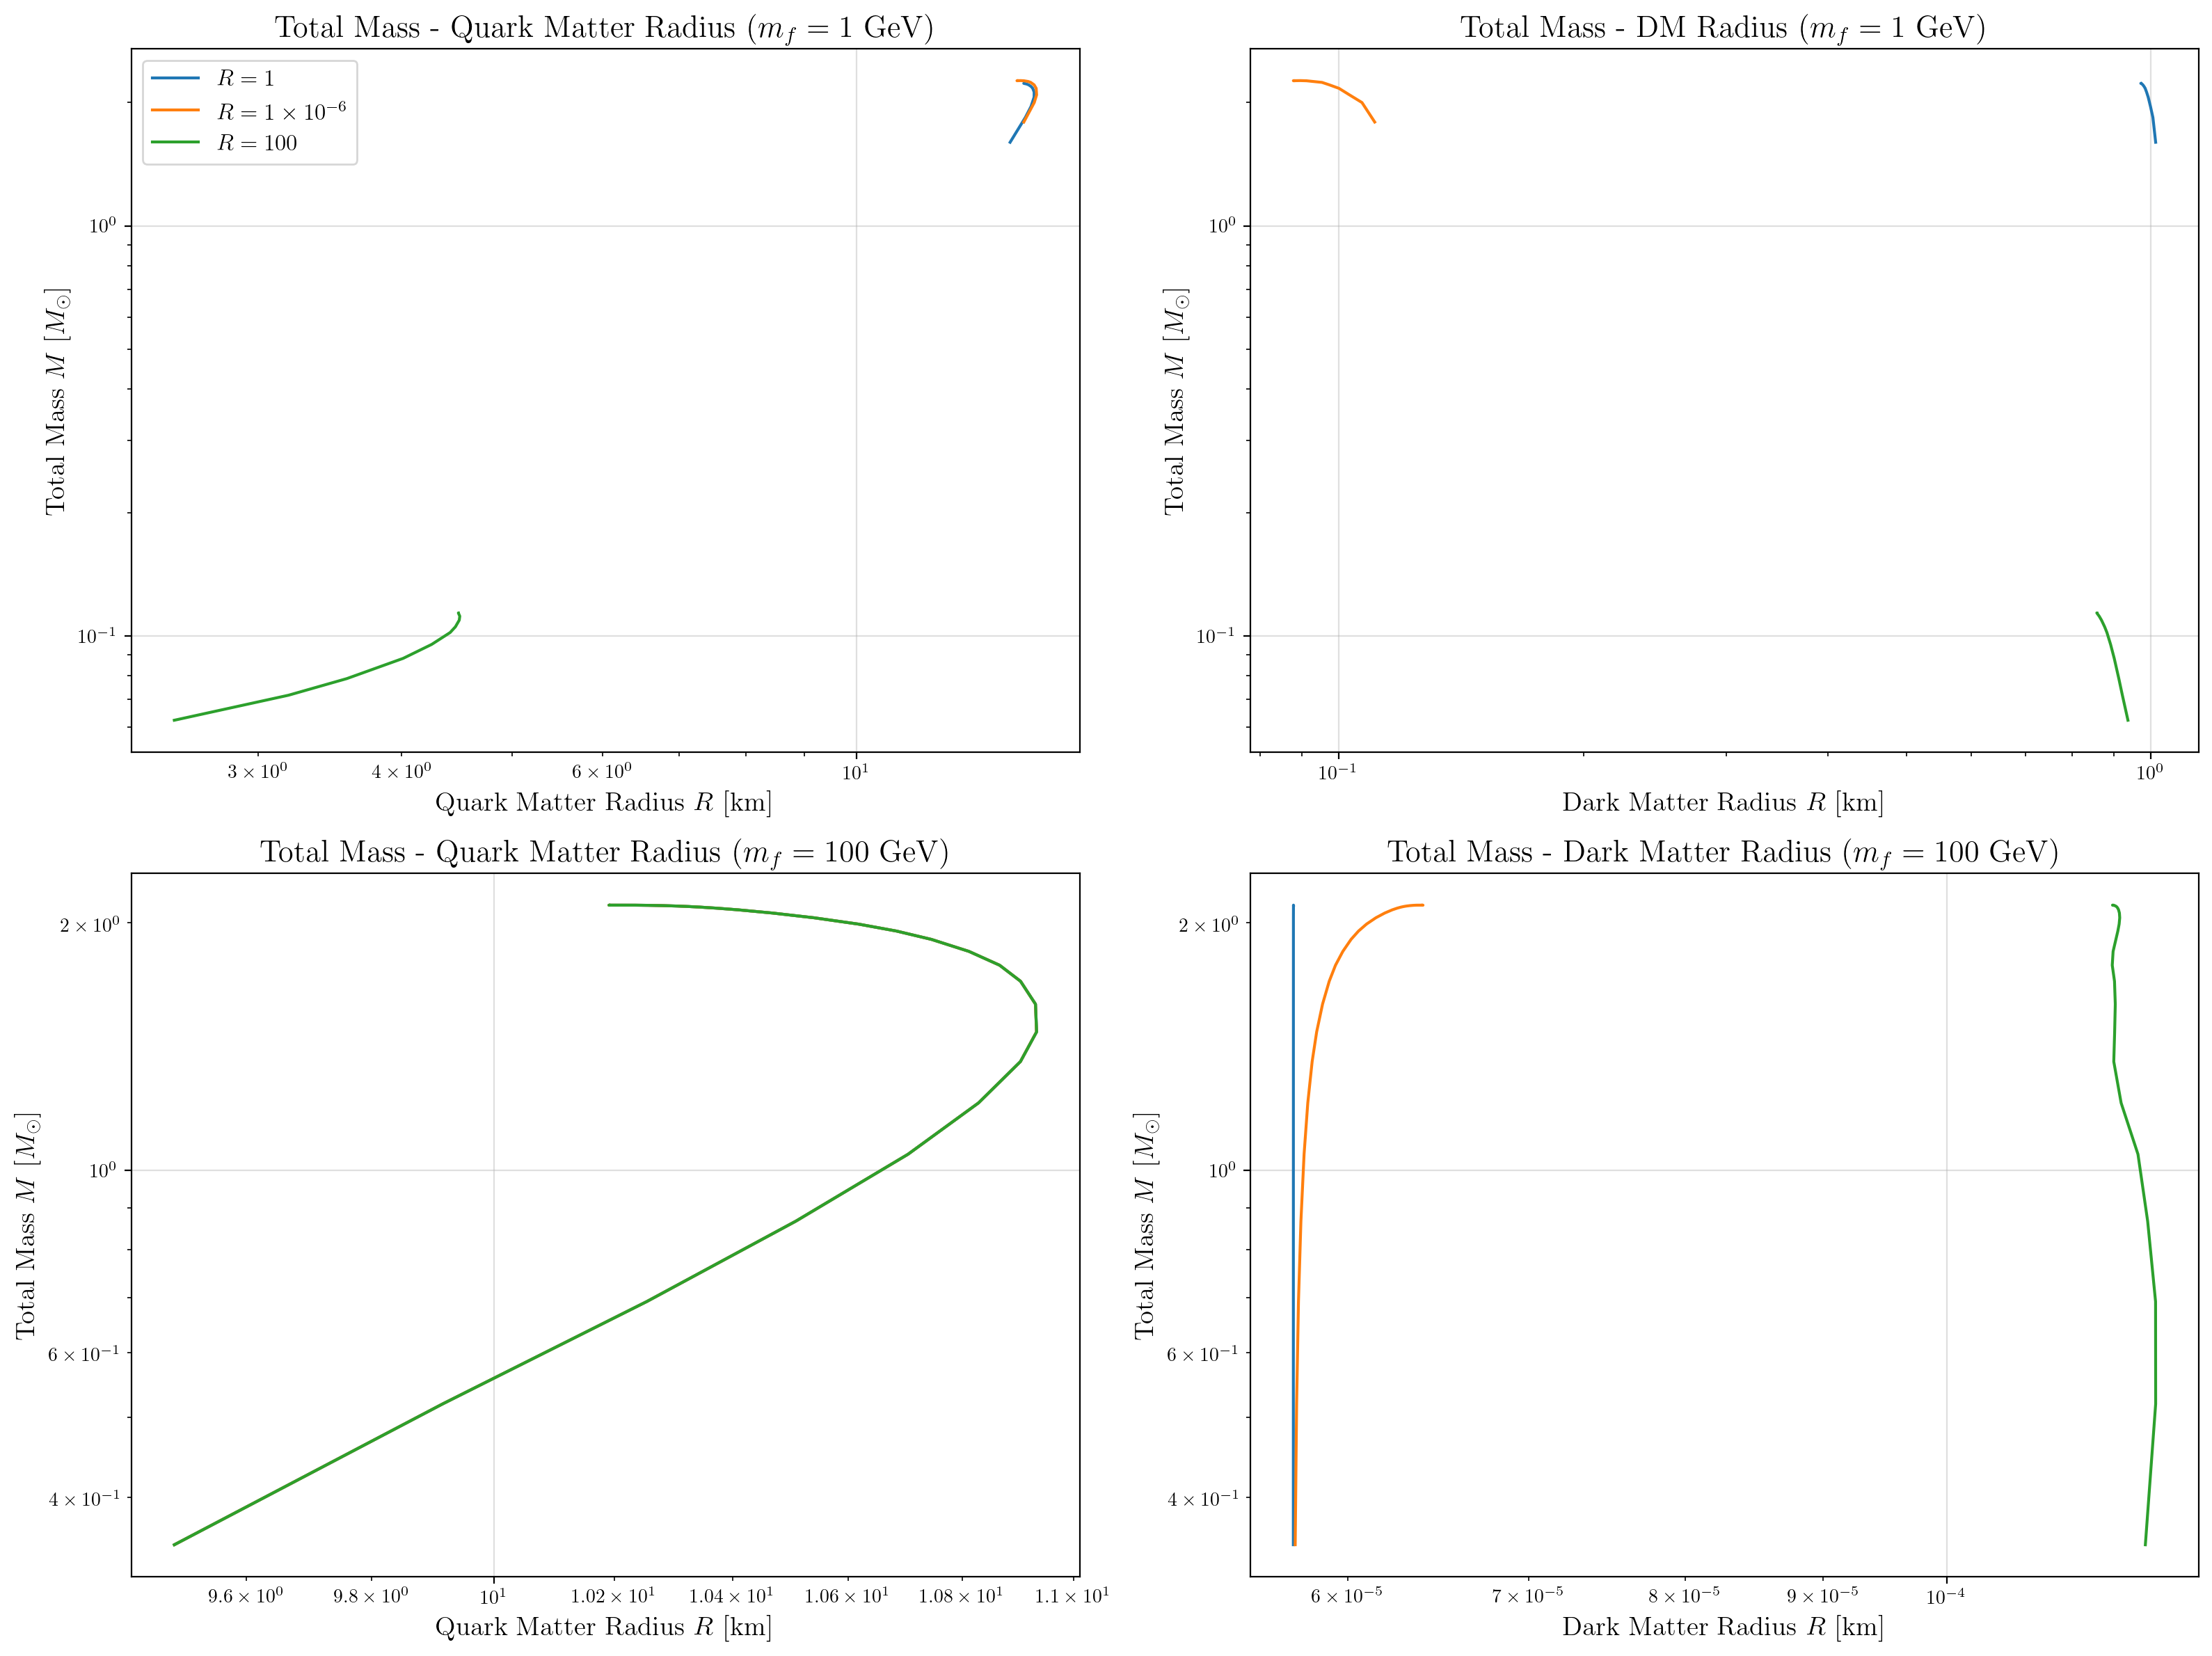

In [42]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns
# Increase figsize so the 4 plots have enough room
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Quark Radius (mf = 1 GeV) ---
# Location: Top Left [0, 0]

axs[0, 0].plot(list_Rqm_1, list_M_1, label=r'$R = 1$')
axs[0, 0].plot(list_Rqm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
axs[0, 0].plot(list_Rqm_100, list_M_100, label=r'$R = 100$')
axs[0, 0].set_xlabel(r' Quark Matter Radius $R$ [km]', fontsize=14)
axs[0, 0].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0, 0].set_title(r'Total Mass - Quark Matter Radius ($m_f =1$ GeV)', fontsize=16)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)



# --- Plot 2: DM Radius (mf = 1 GeV) ---
# Location: Bottom Left [1, 0]

axs[0, 1].plot(list_Rdm_1, list_M_1, label=r'$R = 1$')
axs[0, 1].plot(list_Rdm_1e_6, list_M_1e_6, label=r'$R = 1 \times 10^{-6}$')
axs[0, 1].plot(list_Rdm_100, list_M_100, label=r'$R = 100$')
axs[0, 1].set_xlabel(r' Dark Matter Radius $R$ [km]', fontsize=14)
axs[0, 1].set_ylabel(r' Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0, 1].set_title(r'Total Mass - DM Radius ($m_f =1$ GeV)', fontsize=16)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].grid(True)


# --- Plot 3: Quark Radius (mf = 100 GeV) ---
# Location: Top Right [0, 1]

axs[1, 0].plot(list_Rqm_1e_8_100, list_M_1e_8_100, label=r'$R = 1 \times 10^{-8}$')
axs[1, 0].plot(list_Rqm_1e_5_100, list_M_1e_5_100, label=r'$R = 1 \times 10^{-5}$')
axs[1, 0].plot(list_Rqm_10_100, list_M_10_100, label=r'$R = 10$')
axs[1, 0].set_xlabel(r'Quark Matter Radius $R$ [km]', fontsize=14)
axs[1, 0].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[1, 0].set_title(r'Total Mass - Quark Matter Radius ($m_f =100$ GeV)', fontsize=16)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].grid(True)

# --- Plot 4: DM Radius (mf = 100 GeV) ---
# Location: Bottom Right [1, 1]

axs[1, 1].plot(list_Rdm_1e_8_100, list_M_1e_8_100, label=r'$R = 1 \times 10^{-8}$')
axs[1, 1].plot(list_Rdm_1e_5_100, list_M_1e_5_100, label=r'$R = 1 \times 10^{-5}$')
axs[1, 1].plot(list_Rdm_10_100, list_M_10_100, label=r'$R = 10$')
axs[1, 1].set_xlabel(r'Dark Matter Radius $R$ [km]', fontsize=14)
axs[1, 1].set_ylabel(r'Total Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[1, 1].set_title(r'Total Mass - Dark Matter Radius ($m_f =100$ GeV)', fontsize=16)
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].grid(True)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

In [43]:
# find maximum of total mass, and the corresponding quark and dm aportation


total_mass_1 = np.max(list_M_1)
index = np.argmax(list_M_1)
quark_mass_1 = list_Mqm_1[index]
dm_mass_1 = list_Mdm_1[index]
dm_prop_1 = dm_mass_1 / total_mass_1

total_mass_1e_6 = np.max(list_M_1e_6)
index = np.argmax(list_M_1e_6)
quark_mass_1e_6 = list_Mqm_1e_6[index]
dm_mass_1e_6 = list_Mdm_1e_6[index]
dm_prop_1e_6 = dm_mass_1e_6 / total_mass_1e_6

total_mass_100 = np.max(list_M_100)
index = np.argmax(list_M_100)
quark_mass_100 = list_Mqm_100[index]
dm_mass_100 = list_Mdm_100[index]
dm_prop_100 = dm_mass_100 / total_mass_100


total_mass_1e_8_100 = np.max(list_M_1e_8_100)
index = np.argmax(list_M_1e_8_100)
quark_mass_1e_8_100 = list_Mqm_1e_8_100[index]
dm_mass_1e_8_100 = list_Mdm_1e_8_100[index]
dm_prop_1e_8_100 = dm_mass_1e_8_100 / total_mass_1e_8_100

total_mass_1e_5_100 = np.max(list_M_1e_5_100)
index = np.argmax(list_M_1e_5_100)
quark_mass_1e_5_100 = list_Mqm_1e_5_100[index]
dm_mass_1e_5_100 = list_Mdm_1e_5_100[index]
dm_prop_1e_5_100 = dm_mass_1e_5_100 / total_mass_1e_5_100


total_mass_10_100 = np.max(list_M_10_100)
index = np.argmax(list_M_10_100)
quark_mass_10_100 = list_Mqm_10_100[index]
dm_mass_10_100 = list_Mdm_10_100[index]
dm_prop_10_100 = dm_mass_10_100 / total_mass_10_100

#plot the information of maximum masses and dm proportion
print("mf = 1 GeV")
print(f"R=1e-6: M_total = {total_mass_1e_6:.4e} M_sun, M_quark = {quark_mass_1e_6:.4e} M_sun, M_dm = {dm_mass_1e_6:.4e} M_sun, DM proportion = {dm_prop_1e_6:.4e}")
print(f"R=1:    M_total = {total_mass_1:.4e} M_sun, M_quark = {quark_mass_1:.4e} M_sun, M_dm = {dm_mass_1:.4e} M_sun, DM proportion = {dm_prop_1:.4e}")    
print(f"R=100:  M_total = {total_mass_100:.4e} M_sun, M_quark = {quark_mass_100:.4e} M_sun, M_dm = {dm_mass_100:.4e} M_sun, DM proportion = {dm_prop_100:.4e}")
print()
print("mf = 100 GeV")
print(f"R=1e-5: M_total = {total_mass_1e_8_100:.4e} M_sun, M_quark = {quark_mass_1e_8_100:.4e} M_sun, M_dm = {dm_mass_1e_8_100:.4e} M_sun, DM proportion = {dm_prop_1e_8_100:.4e}")
print(f"R=1e-5: M_total = {total_mass_1e_5_100:.4e} M_sun, M_quark = {quark_mass_1e_5_100:.4e} M_sun, M_dm = {dm_mass_1e_5_100:.4e} M_sun, DM proportion = {dm_prop_1e_5_100:.4e}")
print(f"R=10:   M_total = {total_mass_10_100:.4e} M_sun, M_quark = {quark_mass_10_100:.4e} M_sun, M_dm = {dm_mass_10_100:.4e} M_sun, DM proportion = {dm_prop_10_100:.4e}")


mf = 1 GeV
R=1e-6: M_total = 2.2621e+00 M_sun, M_quark = 2.2621e+00 M_sun, M_dm = 1.1727e-08 M_sun, DM proportion = 5.1839e-09
R=1:    M_total = 2.2271e+00 M_sun, M_quark = 2.2143e+00 M_sun, M_dm = 1.2812e-02 M_sun, DM proportion = 5.7528e-03
R=100:  M_total = 1.1386e-01 M_sun, M_quark = 2.9127e-02 M_sun, M_dm = 8.4731e-02 M_sun, DM proportion = 7.4418e-01

mf = 100 GeV
R=1e-5: M_total = 2.1026e+00 M_sun, M_quark = 2.1026e+00 M_sun, M_dm = 1.1808e-12 M_sun, DM proportion = 5.6161e-13
R=1e-5: M_total = 2.1026e+00 M_sun, M_quark = 2.1026e+00 M_sun, M_dm = 1.6293e-12 M_sun, DM proportion = 7.7490e-13
R=10:   M_total = 2.1026e+00 M_sun, M_quark = 2.1026e+00 M_sun, M_dm = 2.0135e-09 M_sun, DM proportion = 9.5761e-10


For only EOS I: R=0

In [54]:
data = pd.read_csv('../Data/EOSII_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_eos2 = (10 ** data['x']) * hc **3 / (4*B)
grid_p_eos2 = (10 ** data[' y']) * hc **3 / (4*B)



data = pd.read_csv('../Data/EOS1_Mikel.csv') #Mev/fm3

# Extract columns
grid_e_eos1 = (10 ** data['x']) * hc **3 / (4*B)
grid_p_eos1 = (10 ** data[' y']) * hc **3 / (4*B)


central_energy_densities_phys = np.linspace(10,1e4,500) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_eos1, grid_p_eos1)

list_Rqm_0 = []
list_Rdm_0 = []
list_M_0 = []
list_Mqm_0 = []
list_Mdm_0 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_eos1, grid_p_quark=grid_p_eos1, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_0.append(data['R_quark'])
    list_Rdm_0.append(data['R_dm'])
    list_M_0.append(data['M_total'])
    list_Mqm_0.append(data['M_quark'])
    list_Mdm_0.append(data['M_dm'])





central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 
central_pressures = np.interp(central_energy_densities, grid_e_eos2, grid_p_eos2)

list_Rqm_0_eos2 = []
list_Rdm_0_eos2 = []
list_M_0_eos2 = []
list_Mqm_0_eos2 = []
list_Mdm_0_eos2 = []


for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    p_central = central_pressures[i]
    data = compute_two_fluid_properties_ratio(e_central, p_central, R=0, grid_e_quark=grid_e_eos2, grid_p_quark=grid_p_eos2, grid_e_dm=grid_e_dm, grid_p_dm=grid_p_dm)
    list_Rqm_0_eos2.append(data['R_quark'])
    list_Rdm_0_eos2.append(data['R_dm'])
    list_M_0_eos2.append(data['M_total'])
    list_Mqm_0_eos2.append(data['M_quark'])
    list_Mdm_0_eos2.append(data['M_dm'])

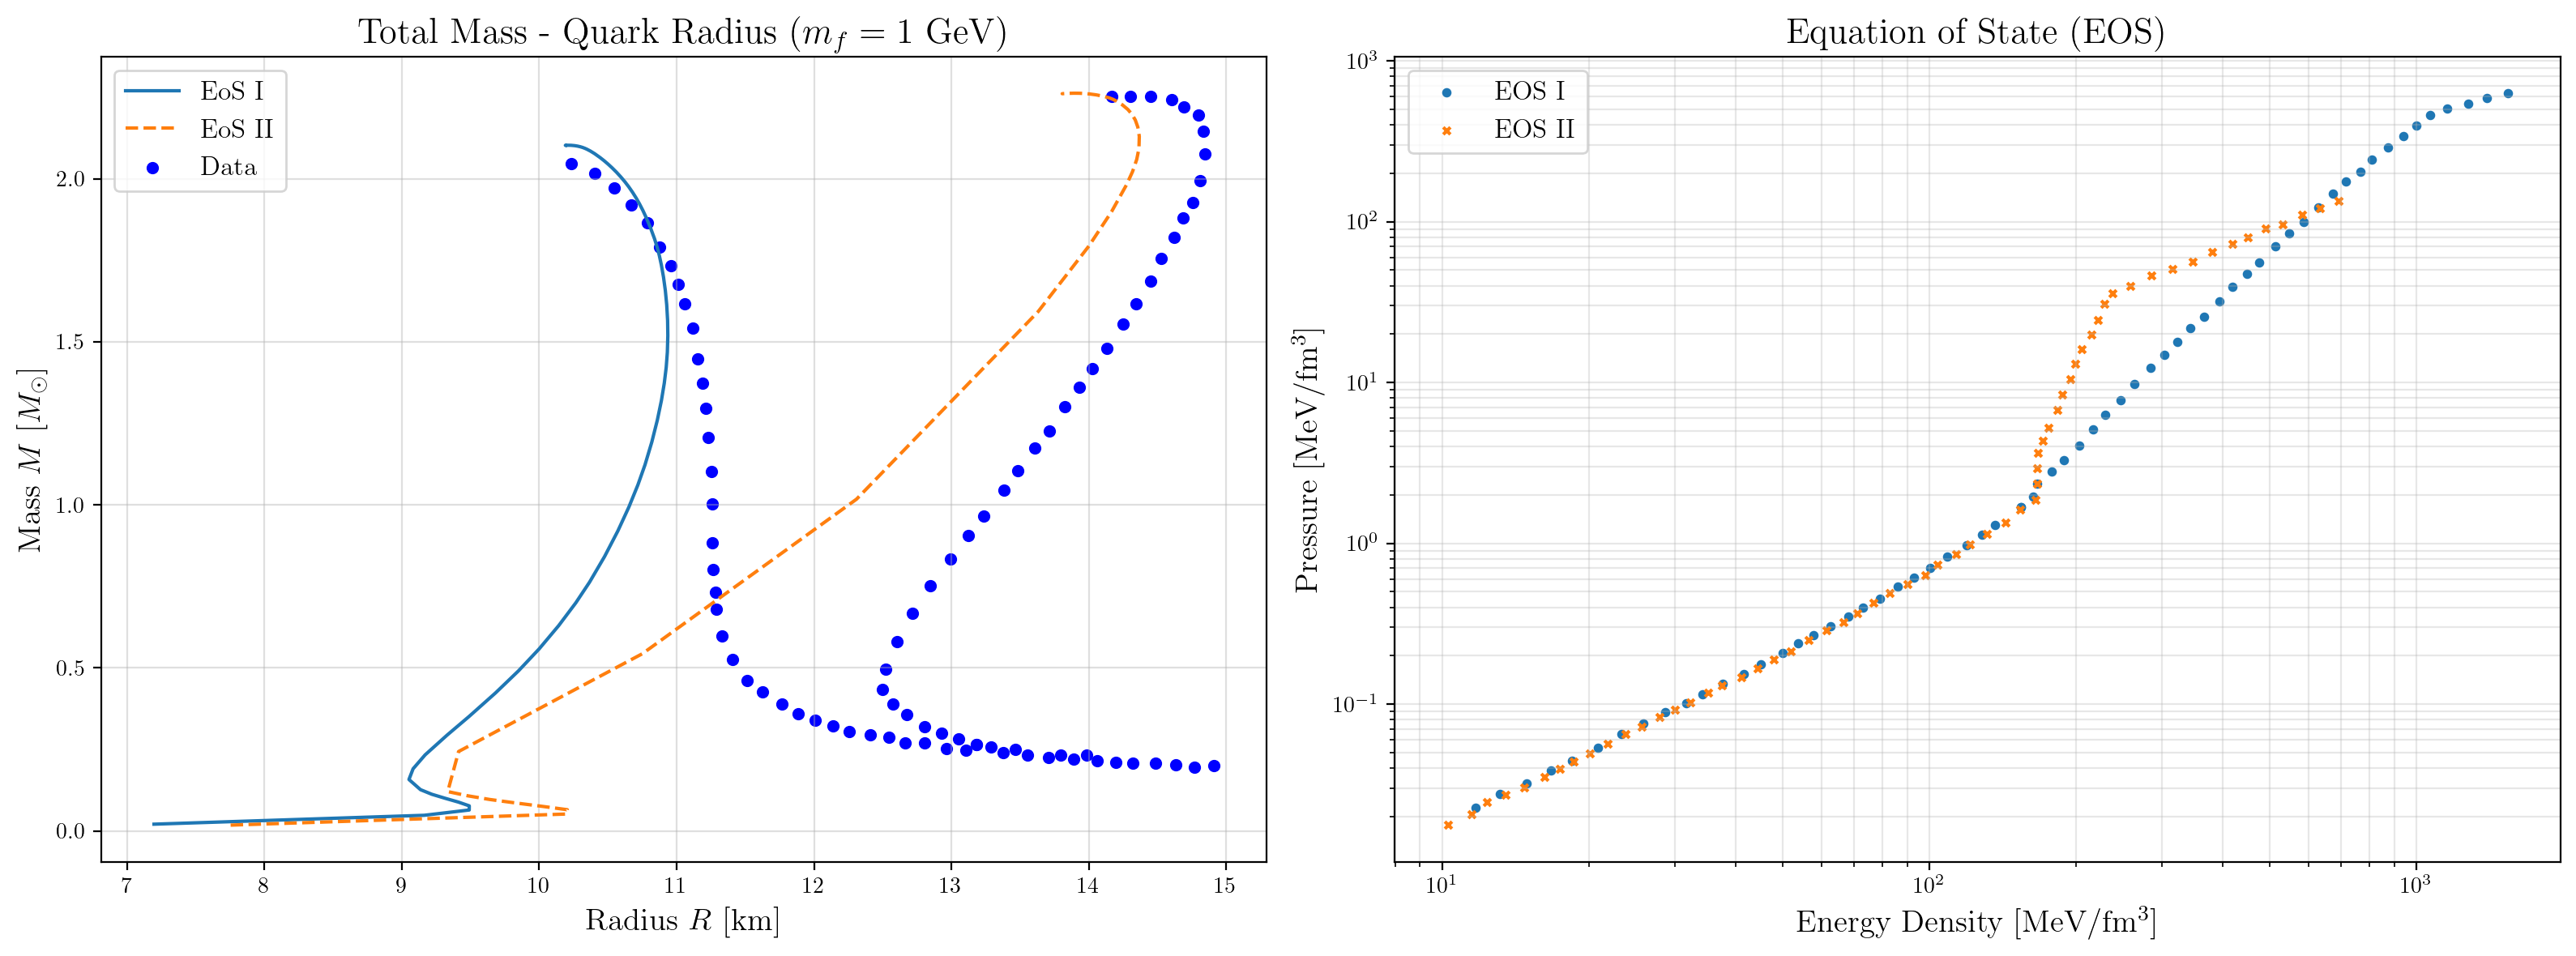

In [57]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

#open a csv file
mr = pd.read_csv('../Data/Mass_radius_EOS1andEOS2.csv')

# --- Plot 1: Mass-Radius Diagram (Left) ---
axs[0].plot(list_Rqm_0, list_M_0, label=r'EoS I')
axs[0].plot(list_Rqm_0_eos2, list_M_0_eos2, label=r'EoS II', linestyle='--') # Added dashed line for contrast
axs[0].scatter(mr['x'], mr[' y'], color='blue', s=20, label='Data')
axs[0].set_xlabel(r'Radius $R$ [km]', fontsize=14)
axs[0].set_ylabel(r'Mass $M$ [$M_{\odot}$]', fontsize=14)
axs[0].set_title(r'Total Mass - Quark Radius ($m_f =1$ GeV)', fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# --- Plot 2: Equation of State (Right) ---
# EOS I Data
grid_p_1 = grid_p_eos1 * factor_P_to_MeV4 / hc**3
grid_e_1 = grid_e_eos1 * factor_P_to_MeV4 / hc**3
axs[1].scatter(grid_e_1, grid_p_1, label='EOS I', s=10)

# EOS II Data
grid_p_2 = grid_p_eos2 * factor_P_to_MeV4 / hc**3
grid_e_2 = grid_e_eos2 * factor_P_to_MeV4 / hc**3
axs[1].scatter(grid_e_2, grid_p_2, label='EOS II', s=10, marker='x') # Changed color/marker

# EOS Plot Formatting
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel('Pressure [MeV/fm$^3$]', fontsize=14)
axs[1].set_xlabel('Energy Density [MeV/fm$^3$]', fontsize=14)
axs[1].set_title('Equation of State (EOS)', fontsize=16)
axs[1].legend(fontsize=12)
axs[1].grid(True, which="both", alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()